In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np
import pandas as pd

In [2]:
import diffxpy.api as de

# Introduction

Perfect confounding occurs frequently in differential expression assays, often if biological replicates cannot be spread across conditions: This is often the case with animals or patients. Perfect confounding implies that the corresponding design matrix is not full rank and the model underdetermined. This can be circumvented by certain tricks (where replicates are modeled as the interaction of condition and and a replicate index per condition) which essentially regress repplicates to reference replicates. We believe that this is firstly undesirable as the condition coefficients depend on the identity of the reference replicates and accordingly on the ordering of the replicates, which has no experiental meaning and is purely a result of sample labels. Secondly, such tricks may be hard to come up with in hard cases. Here, we show how one can solve both problems by constraining parameterse in the model. 

For more examples refer to the constraint tutorial in batchglm (~/tutorials/nb_glm_constraints.ipynb).

# Example 1

In this example, we have 4 biological replicates (animals, patients, cell culture replicates etc.) in a treatment experiment: 2 in each condition (treated, untreated). Accordingly, there is perfect confounding at this level. We circumvent this by constraining the biological replicate coefficients. 

## Simulate data:

### Define design matrices for simulation

Here, we built a one-hot encoded design matrix of discrete covariated (biological replicate and treatment) as a numpy array cells x parameters of model. We will later use this design matrix both for the location and scale model

In [3]:
ncells = 2000
dmat = np.zeros([ncells, 7])
dmat[:,0] = 1
dmat[:500,1] = 1 # bio rep 1
dmat[500:1000,2] = 1 # bio rep 2
dmat[1000:1500,3] = 1 # bio rep 3
dmat[1500:2000,4] = 1 # bio rep 4
dmat[0:1000,5] = 1 # condition effect 0
dmat[1000:2000,6] = 1 # condition effect 1
print(np.unique(dmat, axis=0))

[[1. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 1. 0.]]


### Run simulation

Simulate data using the design matrix defined above.

In [4]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_features=500)
sim.parse_dmat_loc(dmat = dmat)
sim.parse_dmat_scale(dmat = dmat)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

## Prepare model estimation

### Design matrix for estimation

Build design matrix is pandas data frame in which the column names are coefficient names and the rows are cells in the same order as in your data object.

In [5]:
coefficient_names = ['intercept', 'bio1', 'bio2', 'bio3', 'bio4', 'treatment1', 'treatment2']

In [6]:
dmat_est_loc_raw = pd.DataFrame(data=dmat, columns=coefficient_names)
dmat_est_scale_raw = pd.DataFrame(data=dmat[:,[0]], columns=[coefficient_names[0]])

Use the diffxpy design matrix builder / formatting function de.test.design_matrix() to build a design matrix that can be input into diffxpy from the pandas data frame.

In [7]:
dmat_est_loc = de.test.design_matrix(dmat = dmat_est_loc_raw)
dmat_est_scale = de.test.design_matrix(dmat = dmat_est_scale_raw)

### Constraints for model

Build constraints based on sets of parameters that have to sum to zero. Each of these constraints is enforced by binding one of these parameters to the rest of the set. Such a constraint is encoded by assigning a 1 to each parameter in the set and a -1 to to the dependent parameter. The constraints have to be ordered so that they can be iteratively applied from top to bottom and so that all independent parameters (1s) are defined at each stage: A dependent parameter may depend on another dependent parameter if the other dependent parameter was defined in a constrained that lies before the current constraint.

In [8]:
constraints_loc = np.zeros([3, dmat_est_loc.dims['design_params']])
# Constraint 1: Center treatment effects.
constraints_loc[0,5] = -1
constraints_loc[0,6] = 1
# Constraint 1: Account for perfect confouding at biological replicate and treatment level 
# by constraining biological replicate coefficients not to produce mean effects across conditions.
constraints_loc[1,3] = -1
constraints_loc[1,4:5] = 1
# Constraint 2: Account for fact that first level of biological replicates was not absorbed into offset.
constraints_loc[2,1] = -1
constraints_loc[2,2:5] = 1

constraints_loc

array([[ 0.,  0.,  0.,  0.,  0., -1.,  1.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  1.,  1.,  0.,  0.]])

Use the same constraints also for the scale model:

In [9]:
constraints_scale = None

## Differential expression test:

### With constraints on treatment model

In [10]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

test = de.test.wald(
    data = sim.X, # count data
    dmat_loc = dmat_est_loc.data_vars['design'],
    dmat_scale = dmat_est_scale.data_vars['design'],
    constraints_loc = constraints_loc,
    constraints_scale = constraints_scale,
    coef_to_test=["treatment2"],
    training_strategy=[
        {'convergence_criteria': 't_test',
         'learning_rate': 0.05,
         'loss_window_size': 50,
         'optim_algo': 'GD',
         'stop_at_loss_change': 0.005,
         'use_batching': False}
    ]
)

Fitting model...
Using closed-form MLE initialization for mean
Should train mu: False
Using closed-form MME initialization for dispersion
Should train r: True


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlice

training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.05,
  'loss_window_size': 50,
  'optim_algo': 'GD',
  'stop_at_loss_change': 0.005,
  'use_batching': False}]
Beginning with training sequence #1
Training sequence #1 complete


In [26]:
np.median(test.model_gradient)

26.006607733256217

### Obtain the results

/Users/david.fischer/gitDevelopment/diffxpy/diffxpy/testing/base.py:579: RuntimeWarning: invalid value encountered in sqrt
  self.theta_sd = np.sqrt(np.diagonal(self.model_estim.fisher_inv, axis1=-2, axis2=-1)).T[self.sd_loc_totest]
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c36eb7d68>)

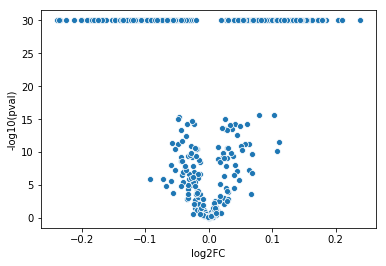

In [11]:
test.plot_volcano()

### Without constraints on treatment model, treatment 1

In [12]:
dmat_est_loc_st1 = de.test.design_matrix(dmat = dmat_est_loc_raw.iloc[:,:-1])
dmat_est_scale_st1 = de.test.design_matrix(dmat = dmat_est_scale_raw)

In [13]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

test_standard1 = de.test.wald(
    data = sim.X, # count data
    dmat_loc = dmat_est_loc_st1.data_vars['design'],
    dmat_scale = dmat_est_scale_st1.data_vars['design'],
    constraints_loc = constraints_loc[1:,:-1],
    constraints_scale = constraints_scale,
    coef_to_test=["treatment1"],
    training_strategy=[
        {'convergence_criteria': 't_test',
         'learning_rate': 0.05,
         'loss_window_size': 50,
         'optim_algo': 'GD',
         'stop_at_loss_change': 0.005,
         'use_batching': False}
    ]
)

Fitting model...
Using closed-form MLE initialization for mean
Should train mu: False
Using closed-form MME initialization for dispersion
Should train r: True


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlice

training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.05,
  'loss_window_size': 50,
  'optim_algo': 'GD',
  'stop_at_loss_change': 0.005,
  'use_batching': False}]
Beginning with training sequence #1
Training sequence #1 complete


In [25]:
np.median(test_standard1.model_gradient)

22.902549584447865

### Without constraints on treatment model, treatment 2

In [14]:
idx_to_keep = np.asarray(range(dmat_est_loc_raw.shape[1]))
idx_to_keep = np.concatenate([idx_to_keep[:-2], idx_to_keep[[-1]]])
dmat_est_loc_st2 = de.test.design_matrix(dmat = dmat_est_loc_raw.iloc[:,idx_to_keep])
dmat_est_scale_st2 = de.test.design_matrix(dmat = dmat_est_scale_raw)

In [15]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

test_standard2 = de.test.wald(
    data = sim.X, # count data
    dmat_loc = dmat_est_loc_st2.data_vars['design'],
    dmat_scale = dmat_est_scale_st2.data_vars['design'],
    constraints_loc = constraints_loc[1:,idx_to_keep],
    constraints_scale = constraints_scale,
    coef_to_test=["treatment2"]
)

Fitting model...
Using closed-form MLE initialization for mean
Should train mu: False
Using closed-form MME initialization for dispersion
Should train r: True


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlice

training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.01,
  'loss_window_size': 10,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.25,
  'use_batching': False}]
Beginning with training sequence #1
Training sequence #1 complete


In [23]:
np.median(test_standard2.model_gradient)

26.04804349603541

### Compare the results

/Users/david.fischer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


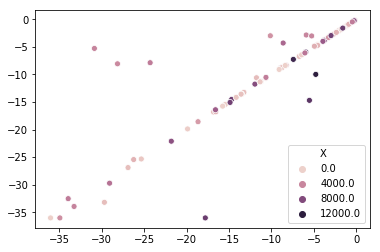

In [18]:
sns.scatterplot(np.log(test_standard1.pval), 
                np.log(test_standard2.pval), 
                hue=test.mean)

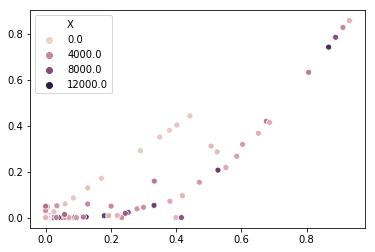

In [20]:
sns.scatterplot(test.pval, 
                test_standard2.pval, 
                hue=test.mean)

/Users/david.fischer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


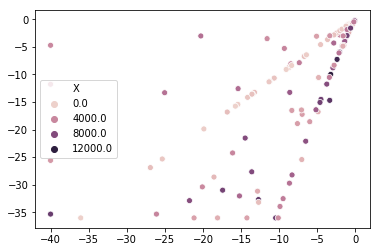

In [47]:
test_logpval = np.log(test.pval)
test_logpval[test_logpval < -40] = -40
sns.scatterplot(test_logpval, 
                np.log(test_standard2.pval), 
                hue=test.mean)

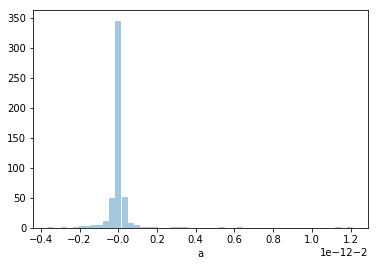

In [44]:
sns.distplot((2*test.model_estim.a[-1,:]-test_standard1.model_estim.a[-1,:])/
             test_standard1.model_estim.a[-1,:], kde=False)

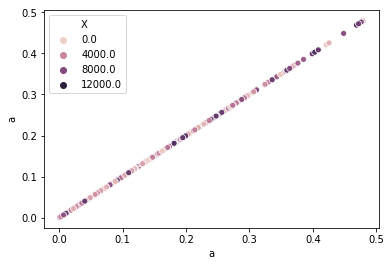

In [45]:
sns.scatterplot(2*np.abs(test.model_estim.a[-1,:]),
                np.abs(test_standard1.model_estim.a[-1,:]),
                hue=test.mean)

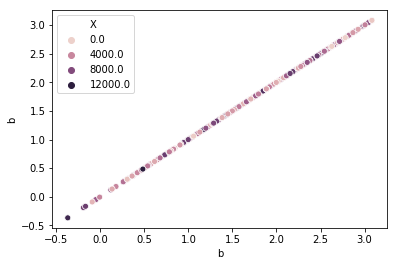

In [41]:
sns.scatterplot(test.model_estim.b[0,:],
                test_standard1.model_estim.b[0,:],
                hue=test.mean)